In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import matplotlib.image as mpimg
import scipy.optimize as so
import cv2
import piexif
import sys
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Image(object):
    def __init__(self, img):
        # Store the Image 
        self.img = plt.imread(img)
        # Image Description
        self.image = piexif.load(img)
        self.h = plt.imread(img).shape[0]  # image width 
        self.w = plt.imread(img).shape[1]  # image height
        self.d = plt.imread(img).shape[2]
        self.f = self.image['Exif'][piexif.ExifIFD.FocalLengthIn35mmFilm]/36*self.w

class camClass(Image):
    def __init__(self):
        self.images = []
        self.pointCloud = [] # Real World Coords
        
        self.x1 = [] # Generalized Coords
        self.x2 = [] 
        
        self.u1 = [] # Image pixel Coords
        self.u2 = [] 

        self.R = None  # Rotation Matrix
        self.t = None  # Translation Matrix
        
    def add_images(self,image):
        self.images.append(image)
    
    def SIFT(self): 
        # Read in images    
        I1 = self.images[0]
        I2 = self.images[1]
        h,w,d,f = I1.h, I1.w, I1.d, I1.f
            
        # Generate SIFT key-points
        sift = cv2.xfeatures2d.SIFT_create()
        kp1,des1 = sift.detectAndCompute(I1.img, None)
        kp2,des2 = sift.detectAndCompute(I2.img, None)
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,des2,k=2)

        # Apply ratio test
        good = []
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                good.append(m)
        u1 = []
        u2 = []
        for m in good:
            u1.append(kp1[m.queryIdx].pt)
            u2.append(kp2[m.trainIdx].pt)

        # Pixel-wise Camera Coordinates
        u1g = np.array(u1)
        u2g = np.array(u2)

        # Make Homogeneous 
        u1h = np.c_[u1g,np.ones(u1g.shape[0])]
        u2h = np.c_[u2g,np.ones(u2g.shape[0])]
        
        # Image Center
        cv = h/2
        cu = w/2

        # Generalized Camera Coordinates
        K_cam = np.array([[f,0,cu],[0,f,cv],[0,0,1]])
        K_inv = np.linalg.inv(K_cam)
        x1 = u1h @ K_inv.T
        x2 = u2h @ K_inv.T
            
        # Find Essential Matrix
        E, inliers = cv2.findEssentialMat(x1[:,:2],x2[:,:2],np.eye(3),method=cv2.RANSAC,threshold=1e-3)
        inliers = inliers.ravel().astype(bool)
        n_in, self.R, self.t,_ = cv2.recoverPose(E,x1[inliers,:2],x2[inliers,:2])
            
        # Filtered Generalized Coordinates
        self.x1 = x1[inliers==True]
        self.x2 = x2[inliers==True]
            
        # Convert Back to Camera Pixel Coordinats
        self.h1 = K_cam@self.x1.T
        self.h2 = K_cam@self.x2.T

def triangulate(P0,P1,x1,x2):
        '''This function returns the real-world coordinates (X,Y,X,W) of key points found in 2 images
            P0 and P1 are poses, x1 and x2 are SIFT key-points'''
        A = np.array([[P0[2,0]*x1[0] - P0[0,0], P0[2,1]*x1[0] - P0[0,1], P0[2,2]*x1[0] - P0[0,2], P0[2,3]*x1[0] - P0[0,3]],                          [P0[2,0]*x1[1] - P0[1,0], P0[2,1]*x1[1] - P0[1,1], P0[2,2]*x1[1] - P0[1,2], P0[2,3]*x1[1] - P0[1,3]],
                      [P1[2,0]*x2[0] - P1[0,0], P1[2,1]*x2[0] - P1[0,1], P1[2,2]*x2[0] - P1[0,2], P1[2,3]*x2[0] - P1[0,3]],
                      [P1[2,0]*x2[1] - P1[1,0], P1[2,1]*x2[1] - P1[1,1], P1[2,2]*x2[1] - P1[1,2], P1[2,3]*x2[1] - P1[1,3]]])
        u,s,vt = np.linalg.svd(A)
        return vt[-1]
        
def genPointCloud(R, t, x1, x2):
    # Relative pose between two cameras
    P0 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]]) # First camera has canonical rotation and t=0        
    P1 = np.hstack((R, t))
    
    pointCloud = []
    
    # Find X,Y,Z,W for all SIFT Keypoints
    for i in range(len(x1)):
        pointCloud.append(triangulate(P0, P1, x1[i], x2[i]))   # Appends to list of points in xyz coordinates

    pointCloud = np.array(pointCloud)
    pointCloud = pointCloud.T / pointCloud[:,3] # Divide everything by W 
    pointCloud = pointCloud[:-1,:] # Drop the last column (W=1)
    return pointCloud        
        
def plotPointCloud(rw_coords):
    #%matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.plot(*rw_coords,'k.')                
    plt.show()
    
class pose_esimation(object):
    def __init__(self):
        self.pose = None 
    
    def residual(self, pose, x2, x3, rwc_gcp):
        #pose = [R11,R12,R13,R21,R22,R23,R31,R32,R33,x,y,z]
        R = pose[:9].reshape(3,3)
        t = pose[9:].reshape(3,1)
        
        rwc_est = genPointCloud(R, t, x2, x3) # pose 3 is the uknown we are optimizing for.  We know image coords x2 and x3
        residual = rwc_est - rwc_gcp.T
        return residual.ravel()
    
    def estimate_pose(self, x2, x3, rwc_gcp):
        """
        This function adjusts the R and t such that difference between calculated real world coords between image 2 and 3
        and image 1 and 2 is minimized
        """
        p_opt = so.least_squares(self.residual, self.pose, method='lm',args=(x2,x3,rwc_gcp))
        #self.pose = p_opt.x
        return p_opt

def p_trans(pose):
    '''Convert a pose matrix to R and t'''
    R = pose[:,:3]
    t = pose[:,3:][:,np.newaxis]
    return R, t

In [3]:
Image1 = Image('sword/sword_0.jpg')
Image2 = Image('sword/sword_1.jpg')
Image3 = Image('sword/sword_2.jpg')

#############################
# Point Cloud image 1 image 2
#############################
keypts1 = camClass()
keypts1.add_images(Image1)
keypts1.add_images(Image2)
keypts1.SIFT()

# Pixel Coord Keypoints
h11 = keypts1.h1.T[:,:-1]  # Keypoint coords (u,v) of Image 1 based on matching between image 1 and 2
h12 = keypts1.h2.T[:,:-1]  # Keypoint coords (u,v) of Image 2 based on matching between image 1 and 2

# Keypoints generalized cam coordinates
x11 = keypts1.x1 
x12 = keypts1.x2

R12 = keypts1.R # Rotation Matrix, Iteration 1 Image 2
t12 = keypts1.t # Translation Matrix

# PointCloud (Image 1 and 2)
rwc_1 = genPointCloud(R12, t12, x11, x12)


#############################
# Point Cloud image 2 image 3
#############################
keypts2 = camClass()
keypts2.add_images(Image2)
keypts2.add_images(Image3)
keypts2.SIFT()

# Pixel Coord Keypoints
h22 = keypts2.h1.T[:,:-1]  # Keypoint coords (u,v) of Image 2 based on matching between image 2 and 3
h23 = keypts2.h2.T[:,:-1]  # Keypoint coords (u,v) of Image 3 based on matching between image 2 and 3

# Keypoints generalized cam coordinates
x22 = keypts2.x1  
x23 = keypts2.x2

R23 = keypts2.R # Rotation Matrix, Iteration 2 Image 3
t23 = keypts2.t # Translation Matrix

In [4]:
# Find image 3 key points that have correspondance in image 1
keypts_idx = []
rwc_idx = []

for i in range(h12.shape[0]):
    for j in range(h22.shape[0]):
        if (np.allclose(h12[i], h22[j])):  #If image 2 u,v coordinates are equal between the two matching iterations
            keypts_idx.append(j)           #Store that index
            rwc_idx.append(i)
            break

# Filter out non-correspondances
x1_matched = x11[rwc_idx] # Image 2 coordinates for pose estimation
x2_matched = x22[keypts_idx]     # Image 2 coordinates for pose estimation
x3_matched = x23[keypts_idx]     # Image 3 coordinates for pose estimation

rwc_matched = rwc_1.T[rwc_idx,:] # Real world coordinates for pose estimation

#h3_matched = h23[keypts_idx] 

In [ ]:
# Estimate the pose of image 3
get_pose3 = pose_esimation()

# Pose Guess
P2 = np.hstack((R12, t12)) 
P3_prime = np.hstack((R23, t23))
pose3_guess = np.multiply(P2,P3_prime)
R3_guess, t3_guess = p_trans(pose3_guess)
pose3_guess = np.append(R3_guess,t3_guess)
get_pose3.pose = pose3_guess

# Optimize for pose
pose3 = get_pose3.estimate_pose(x2_matched, x3_matched, rwc_matched).x

# Get the Real World Coordinates with optimized pose
R3 = pose3[:9].reshape(3,3)
t3 = pose3[9:].reshape(3,1)
rwc_23 = genPointCloud(R3, t3, x2_matched, x3_matched)

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot(*rwc_matched.T,'k.')  
ax.plot(*rwc_23, 'r.')
plt.show()

<IPython.core.display.Javascript object>


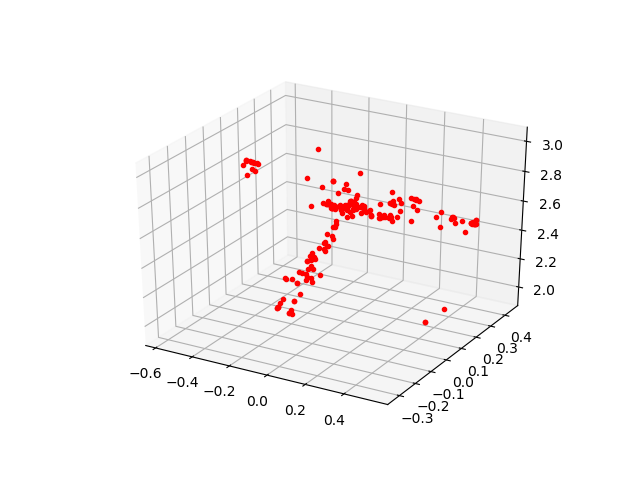

In [6]:
# Generate the full point cloud
rwc_2 = genPointCloud(R3, t3, x22, x23)
rwc_all = np.hstack((rwc_1, rwc_2))

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d') 
ax.plot(*rwc_all, 'r.')
plt.show()

<IPython.core.display.Javascript object>


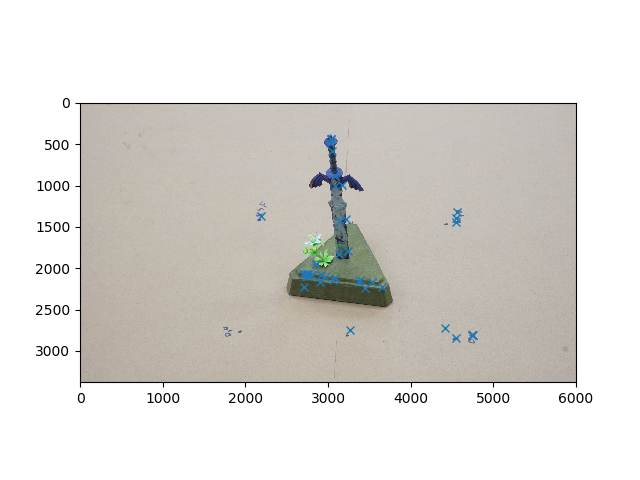

<IPython.core.display.Javascript object>


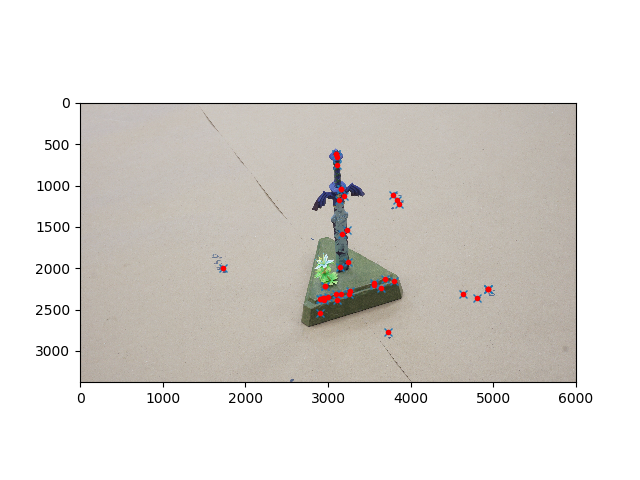

<IPython.core.display.Javascript object>


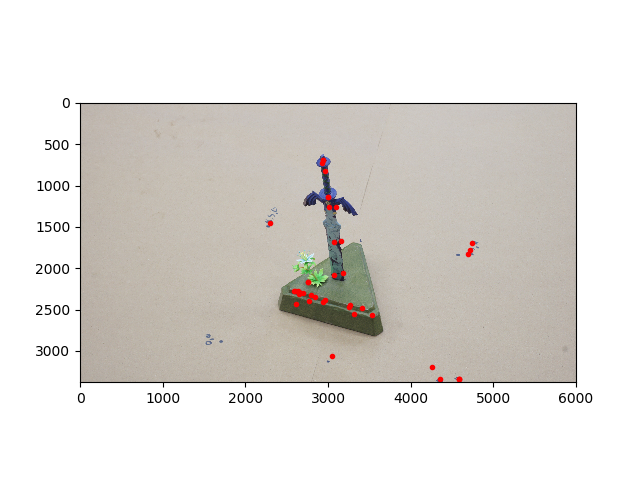

'\nclass t_esimation(object):\n    def __init__(self):\n        self.t = None\n    \n    def residual(self, t, R, x2, x3, rwc_12):\n        \n        t = t.reshape(3,1)\n        \n        rwc23 = genPointCloud(R, t, x2, x3) # pose 3 is the uknown we are optimizing for.  We know image coords x2 and x3\n        #residual = rwc23.flatten() - rwc_12.T.flatten()\n        residual = rwc23 - rwc_12.T\n        return residual.ravel()\n    \n    def estimate_t(self, R, x2, x3, rwc_12):\n        """\n        This function adjusts the R and t such that difference between calculated real world coords between image 2 and 3\n        and image 1 and 2 is minimized\n        """\n        t_opt = so.least_squares(self.residual, self.t, method=\'lm\',args=(R,x2,x3,rwc_12))\n\n        return t_opt\n\n\n\n# Estimate the pose of image 3\nget_t3 = t_esimation()\n\n# Pose Guess\nP2 = np.hstack((R12, t12))\nP3_prime = np.hstack((R23, t23))\n\npose_guess = np.multiply(P2,P3_prime)\nR = pose_guess[:,:3]\nt_guess

In [7]:
# Test point Correspondences
fig, ax = plt.subplots(ncols=1, nrows=1)
img1 = plt.imread('sword/sword_0.jpg')
ax.imshow(img1)
ax.plot(h11[rwc_idx][:,0], h11[rwc_idx][:,1], 'x')
plt.show()

fig, ax = plt.subplots(ncols=1, nrows=1)
img2 = plt.imread('sword/sword_1.jpg')
ax.imshow(img2)
ax.plot(h12[:,0][rwc_idx], h12[rwc_idx][:,1], 'x')
ax.plot(h22[:,0][keypts_idx], h22[:,1][keypts_idx], 'r.')
plt.show()

fig, ax = plt.subplots(ncols=1, nrows=1)
img3 = plt.imread('sword/sword_2.jpg')
ax.imshow(img3)
ax.plot(h23[:,0][keypts_idx], h23[:,1][keypts_idx], 'r.')
plt.show()



'''
class t_esimation(object):
    def __init__(self):
        self.t = None
    
    def residual(self, t, R, x2, x3, rwc_12):
        
        t = t.reshape(3,1)
        
        rwc23 = genPointCloud(R, t, x2, x3) # pose 3 is the uknown we are optimizing for.  We know image coords x2 and x3
        #residual = rwc23.flatten() - rwc_12.T.flatten()
        residual = rwc23 - rwc_12.T
        return residual.ravel()
    
    def estimate_t(self, R, x2, x3, rwc_12):
        """
        This function adjusts the R and t such that difference between calculated real world coords between image 2 and 3
        and image 1 and 2 is minimized
        """
        t_opt = so.least_squares(self.residual, self.t, method='lm',args=(R,x2,x3,rwc_12))

        return t_opt



# Estimate the pose of image 3
get_t3 = t_esimation()

# Pose Guess
P2 = np.hstack((R12, t12))
P3_prime = np.hstack((R23, t23))

pose_guess = np.multiply(P2,P3_prime)
R = pose_guess[:,:3]
t_guess = pose_guess[:,-1][:,np.newaxis].flatten()

# Optimize for pose
get_t3.t = t_guess

t3 = get_t3.estimate_t(R, keypts2_matched_x, keypts3_matched_x, rw_coords_matched).x
t3 = t3[:,np.newaxis]

# Real World Coordinates
RWC_23 = genPointCloud(R, t3, keypts2_matched_x, keypts3_matched_x)

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot(*rw_coords_matched.T,'k.')  
ax.plot(*RWC_23, 'r.')
plt.show()
'''